Imports

In [10]:
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment
from solver import GASolver
from visualize import visualize_schedule_demo
import objective_function

Read from Source

In [11]:
n_workstations, recipes, operation_times = get_data(0)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

Create Orders

In [12]:
earliest_slot = 0
last_slot = 100
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, last_slot, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


Translate for Solver

In [13]:
# translate datamodel to encoding
encoder = EncodeForGA()
# TODO: alternatives can be completely removed (TEST first)
values, durations, all_jobs, alternatives = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job


Run Solver

In [14]:
# create solver object
crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stocastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
population_size = 50
offspring_amount = 100
max_generations = 2000

solver = GASolver(values, durations, all_jobs, alternatives, env, orders)
solver.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection)
solver.run()

Done


Result Output

In [15]:
result = solver.get_best()
selected_tasks = solver.get_result_jobs() # selected task alternatives
fitness = solver.get_best_fitness()
print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 3 14  3 15  3 22  0  0  1  2  1  8  2  0  1 13  3 26  3 28  0  2  0  3
  4  0  4  2  0  8  2  6  1 14  2  8  2 14  4 16  3 29  4  7  1 15  0 21
  2 16  4 20  0 25  0 12  4 25]
Fitness value of the best solution = 30


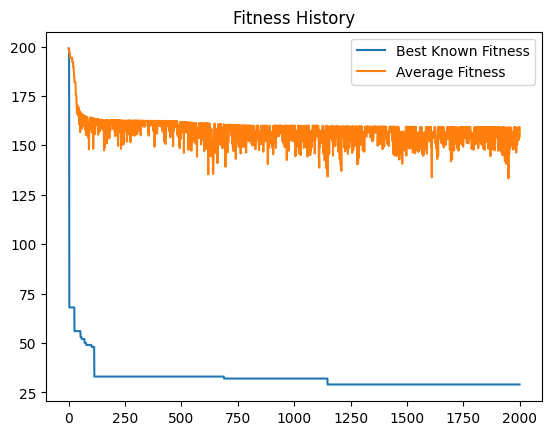

In [16]:
import matplotlib.pyplot as plt
x = list(range(0, len(fitness_history)))
plt.plot(x, fitness_history)
plt.plot(x, average_fitness_history)
plt.title('Fitness History')
plt.legend(['Best Known Fitness', 'Average Fitness'])
plt.xlabel = 'Generation'
plt.ylabel = 'Fitness'
plt.show()

(Optional) Postprocessing

Translate to Schedule

In [17]:
schedule = GAToScheduleTranslator().translate(result, selected_tasks, env, orders)
"""for workstation in schedule.assignments:
    for assignment in schedule.assignments[workstation]:
        print(f'Workstation: {workstation}, Task: {assignment[0]}, Start Time: {assignment[1]}, Duration: {durations[assignment[0]][workstation]}')"""
visualize_schedule_demo(schedule, env, orders)

Evaluate Schedule

In [18]:
#NOTE: the objective functions in this case assume the solution is feasible, no additional checks
#NOTE: currently the only objective function used during optimization is makespan
makespan, tardiness, deviation, idle_time, profit = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespan: {makespan}\nTardiness: {tardiness}\nDeviation: {deviation}\nIdle Time: {idle_time}\nProfit: {profit}')

Fitness Values:
Makespan: 30
Tardiness: 0
Deviation: 786
Idle Time: 25
Profit: 5000
